# <img src="assets/carat_logo.png" alt="CarAT Logo" width="100" height="auto" style="vertical-align: middle;"> CarAT Example: Calculating Biogenic Carbon Content for a Toluene Diisocyanate Case Study 

This notebook demonstrates how to use CarAT to calculate the biogenic carbon content of a chemical value chain. The example workflow uses an industrial Toluene Diisocyanate (TDI) value chain case study. We perform the following steps:

1. Import necessary libraries.

2. Load the pre-built value chain graph and example dataset.

3. Visualise the value chain graph.
4. Inspect the Bill of Materials (BOM).
5. Compute and visualise the Bill-of-Atoms (psi) values (atom mapping).
6. Preprocess the data for Linear Program (LP) optimisation.
7. Formulate and solve the LP model to optimise the value chain.
8. Visualise the results using a Sankey diagram.

## 1. Import Libraries

First, we import all the required Python libraries and modules from the `carat` package.

In [ ]:
import pandas as pd
import pickle 

from carat.utils import get_example_data
from carat.core import compute_psi, LPFormulator
from carat.processing import DataPreprocessor, PreProcessConfig
from carat.vis import mermaid_plot, SankeyDiagramGenerator


/opt/anaconda3/envs/testcarat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Data

Next, we load the value chain graph, which is a pre-built `networkx.DiGraph` object representing the connections between different processes and products. We also load an example dataset containing the Bill of Materials (BOM) and other relevant information.

In [ ]:
# Load value chain graph
graph = pickle.load(open("data/graph.pkl", "rb"))


## 3. Visualise Value Chain Graph

We can visualise the loaded `Networkx DiGraph` using the `mermaid_plot` function, which generates a Mermaid diagram representation of the value chain.

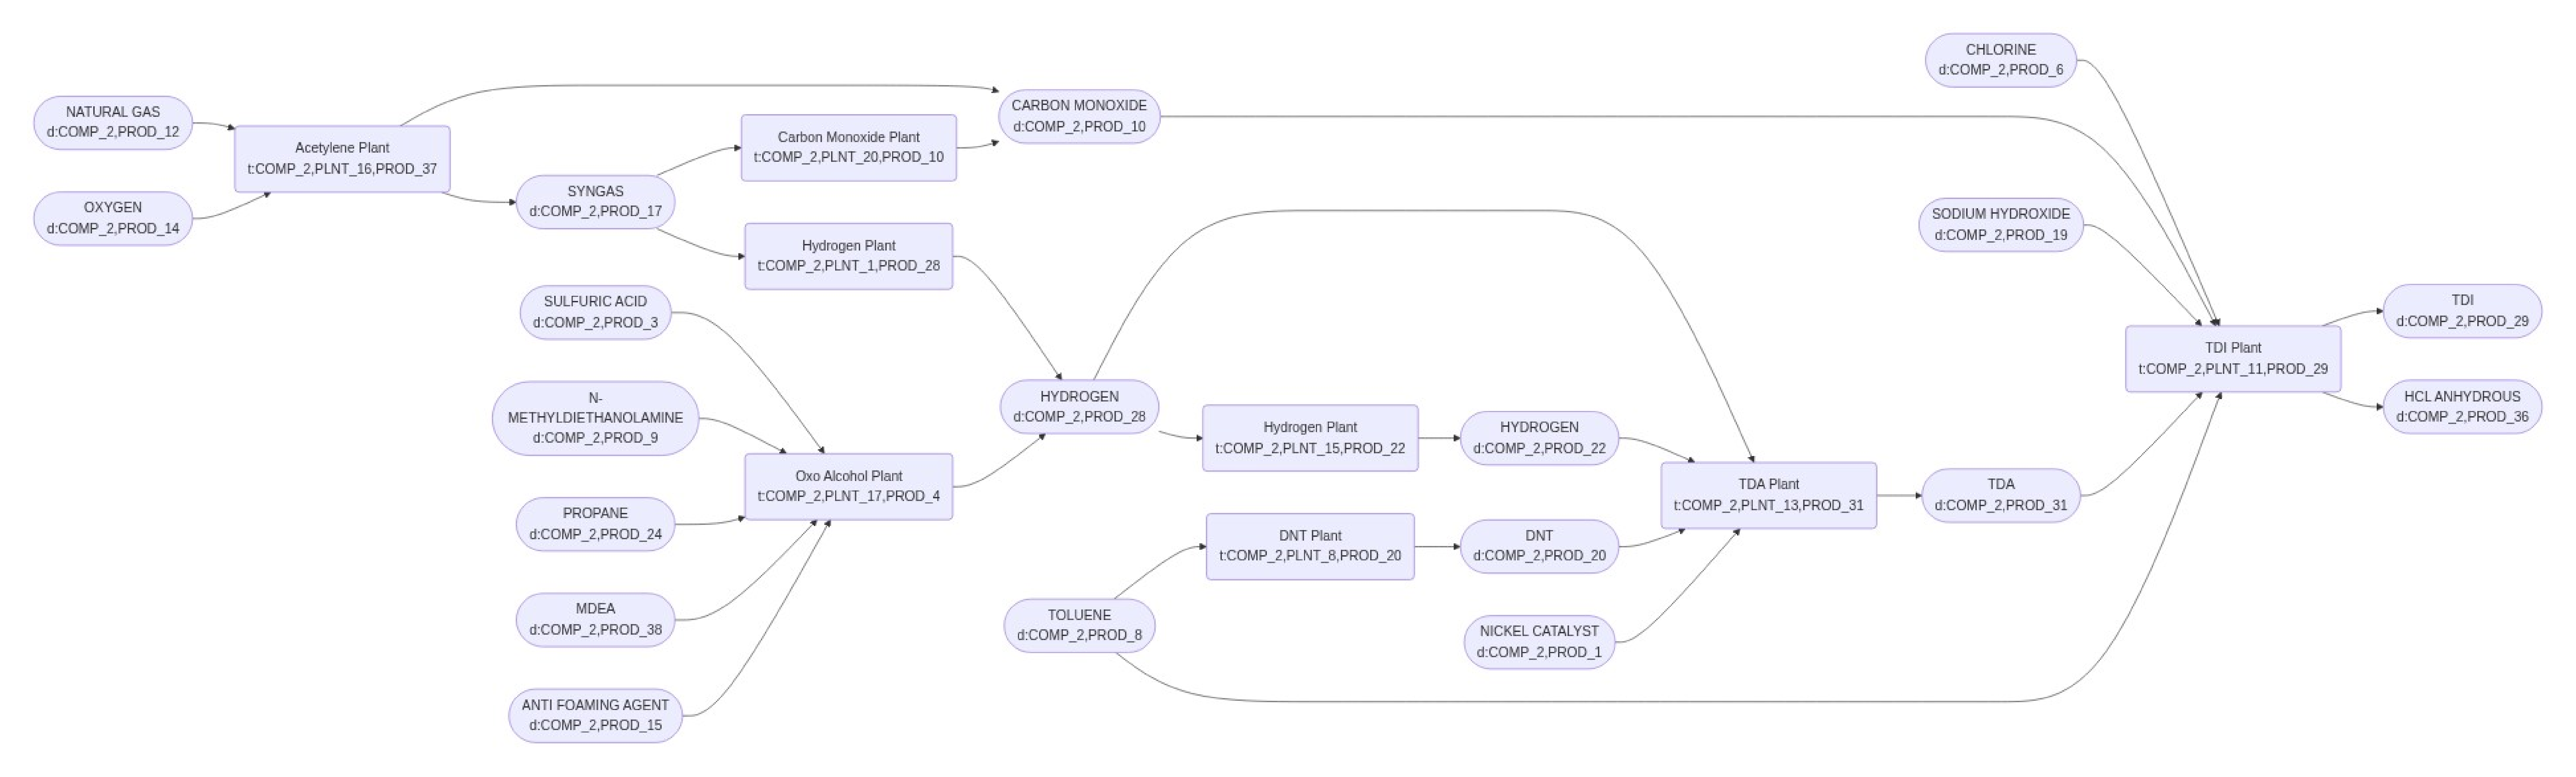

In [ ]:
# Visualise value chain graph
mermaid_plot(graph)


## 4. Inspect Bill of Materials (BOM)

The bill-of-materials (BOM) is the list of materials present at each triplet (production facility). Let's load the example data and take a look at the `trip_bom` to understand its structure. 

In [ ]:
# Load value chain dataset for example
data = get_example_data("data/tdi_anon_dict.pkl")

# Visualise the bill of materials
data['trip_bom'].tail()


PBG_TXT MOV_CAT  \
COCD   BP      PBG_GR  PBG     SMILES                                        
COMP_2 PLNT_16 PROD_37 PROD_17 [HH]          1:1 SYNGAS 1:1 SYNGAS      BY   
                       PROD_37 C#C         ACETYLENE JOINT VENTURE      GR   
                               C#CC        ACETYLENE JOINT VENTURE      GR   
                               C=C=C       ACETYLENE JOINT VENTURE      GR   
                       PROD_30 CN1CCCC1=O     NMP-POLYMER SOLUTION      BY   

                                           RATIO BP_TXT  
COCD   BP      PBG_GR  PBG     SMILES                    
COMP_2 PLNT_16 PROD_37 PROD_17 [HH]         4.53    NaN  
                       PROD_37 C#C          1.41    NaN  
                               C#CC         0.02    NaN  
                               C=C=C        0.01    NaN  
                       PROD_30 CN1CCCC1=O   0.01    NaN

## 5. Compute Bill-of-Atoms (psi)

The bill-of-atoms (psi) represents the atom mapping from inputs to outputs for each process, this is automated using the `RXNMapper` transformer model. We get `psi` using the `compute_psi` function and then convert it to a Pandas DataFrame for easier visualization. We then display an example for a specific triplet (production facility).

In [5]:
# Atom mapping with RXNMapper - use the consistent variable name
psi = compute_psi(data['trip_bom'])

# Convert the nested dictionary `psi` to a DataFrame
psi_df = pd.DataFrame.from_dict(psi, orient='columns')

# Visualise an example boa for a triplet
psi_df['t:COMP_2|PLNT_11|PROD_29'].dropna()


PROD_31  Cc1ccc(N)cc1N  PROD_29  Cc1ccc(N=C=O)cc1N=C=O  C    0.777778
PROD_17  [C-]#[O+]      PROD_29  Cc1ccc(N=C=O)cc1N=C=O  C    0.222222
                        PROD_36  O=C=O                  C    1.000000
                        PROD_17  [C-]#[O+]              C    1.000000
Name: t:COMP_2|PLNT_11|PROD_29, dtype: float64

## 6. Preprocess Data for LP Formulation

Before we can formulate the Linear Program (LP) model, the data needs to be preprocessed. We use `PreProcessConfig` to define the configuration and `DataPreprocessor` to perform the actual preprocessing steps. This involves aligning the BOM data with the graph structure and preparing it for the LP solver.

In [ ]:
# Prepcrocess the data for LP formulation
config = PreProcessConfig(graph=graph, **data)

preprocessed_data = DataPreprocessor(config).preprocess()


## 7. Formulate and Solve LP Model

In this step, we formulate the Linear Program (LP) using the `LPFormulator` class. The preprocessed data is passed as input, along with the desired inlets. The inlets define the composition of the value chain feedstocks, i.e., the fossil/biogenic percentage. 

For this TDI example, we set the inlets to "C1", which specifies that all inlets are fossil-based, except for natural gas, which is set to 100% biogenic. Once the LP problem is formulated, we solve it to compute the biogenic carbon content flows across the value chain.

In [7]:
# Formulate and solve LP model
lp_solver = LPFormulator(preprocessed_data, inlets="C1")
results = lp_solver.solve(output_results=True, pkl_output_path="")


INFO:carat.core.lp_opt:Beta_d:
      COCD      PBG                               SMILES ELEMENT ATTRIBUTE  \
0   COMP_2  PROD_20  Cc1c([N+](=O)[O-])cccc1[N+](=O)[O-]       C    fossil   
1   COMP_2  PROD_20  Cc1c([N+](=O)[O-])cccc1[N+](=O)[O-]       C  biogenic   
2   COMP_1  PROD_27                                  [C]       C    fossil   
3   COMP_1  PROD_27                                  [C]       C  biogenic   
4   COMP_1  PROD_32                                  [C]       C    fossil   
5   COMP_1  PROD_32                                  [C]       C  biogenic   
6   COMP_2  PROD_38                             C1CNCCN1       C    fossil   
7   COMP_2  PROD_38                             C1CNCCN1       C  biogenic   
8   COMP_2  PROD_15   C[Si](C)(C)O[Si](C)(C)O[Si](C)(C)C       C    fossil   
9   COMP_2  PROD_15   C[Si](C)(C)O[Si](C)(C)O[Si](C)(C)C       C  biogenic   
10  COMP_2   PROD_8                            Cc1ccccc1       C    fossil   
11  COMP_2   PROD_8              

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Jan 16 2024
Starting solution of the Linear programming problem using Dual Simplex

Coin0506I Presolve 0 (-206) rows, 0 (-180) columns and 0 (-550) elements
Clp0000I Optimal - objective value 0
Coin0511I After Postsolve, objective 0, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 0 - 0 iterations time 0.002, Presolve 0.00


## 8. Sankey Visualisation

Finally, we visualise the results of the LP optimisation using a Sankey diagram. The `SankeyDiagramGenerator` takes the graph and the LP results (beta_d_res for duplet flows and beta_t_res for triplet flows) as input. We prepare the data, generate the diagram with a title and specified dimensions, display it, and save it as an HTML file.

In [ ]:
# Extract LP results for the Sankey diagram
beta_t_res = results["beta_t_res"]
beta_d_res = results["beta_d_res"]

# Initialize the generator
generator = SankeyDiagramGenerator(graph, beta_d_res, beta_t_res)

# Prepare the data
generator.prepare_data()

# Generate the diagram
fig = generator.generate_sankey_diagram(
    title="CaraAT - Toluene Diisocyanate Case Study", width=1200, height=800
)

# Display the diagram
generator.display_diagram(fig)

# Save the diagram
generator.save_diagram(fig, "assets/sankey_diagram.html", scale=3)


Diagram saved as assets/sankey_diagram.html
